In [87]:
import os
import pandas as pd
import javalang
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
def read_java_file(file_path):
    """Function to read a Java file and return its content as a string."""
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    return content

In [27]:
def extract_ast_nodes(code):
    """Extract AST nodes from Java code."""
    try:
        tokens = list(javalang.tokenizer.tokenize(code))
        parser = javalang.parser.Parser(tokens)
        tree = parser.parse()

        ast_nodes = []
        for path, node in tree:
            if isinstance(node, javalang.tree.Node):
                ast_nodes.append(node.__class__.__name__)
        return ' '.join(ast_nodes)
    except (javalang.parser.JavaSyntaxError, javalang.tokenizer.LexerError) as e:
        print(f"Error al analizar el código Java: {e}")
        return ''

In [28]:
def preprocess_data_with_ast(directory):
    """Preprocess all Java files in the specified directory and return a DataFrame."""
    data = []
    labels_path = os.path.join(directory, 'versions', 'labels.csv')  # Correct path to labels.csv
    labels = pd.read_csv(labels_path)
    
    # Verificar las columnas del archivo CSV
    print("Columnas disponibles en labels.csv:", labels.columns)
    
    # Asegurarse de que la columna correcta está presente
    label_column = 'veredict'  # Cambia esto si el nombre de la columna es diferente
    if label_column not in labels.columns:
        raise KeyError(f"La columna '{label_column}' no se encuentra en labels.csv")
    
    for index, row in labels.iterrows():
        sub1 = row['sub1']
        sub2 = row['sub2']
        label = row[label_column]  # Use the correct label column
        pair_id = f"{sub1}_{sub2}"  # Construct pair_id from sub1 and sub2
        pair_folder = os.path.join(directory, 'versions', 'version_2', pair_id)
        
        # Paths to the two Java files in the pair folder
        file1_path = os.path.join(pair_folder, f"{sub1}.java")
        file2_path = os.path.join(pair_folder, f"{sub2}.java")
        
        # Read and extract AST nodes from both files
        if os.path.exists(file1_path) and os.path.exists(file2_path):
            code1 = read_java_file(file1_path)
            code2 = read_java_file(file2_path)
            ast_nodes1 = extract_ast_nodes(code1)
            ast_nodes2 = extract_ast_nodes(code2)
            
            if ast_nodes1 and ast_nodes2:  # Only combine if both are non-empty
                # Combine the AST nodes from both files
                combined_ast_nodes = ast_nodes1 + ' ' + ast_nodes2
                data.append([combined_ast_nodes, label])
    
    return pd.DataFrame(data, columns=['code', 'label'])

In [29]:
# Usage
data_directory = r'C:\Users\droid\Documents\Aplicaciones_Avanzadas\Proyecto\PlagiarismDetector\data\conplag_version_2'
processed_data = preprocess_data_with_ast(data_directory)
print(processed_data.head())

Columnas disponibles en labels.csv: Index(['sub1', 'sub2', 'problem', 'veredict'], dtype='object')
Error al analizar el código Java: 
                                                code  label
0  CompilationUnit Import Import ClassDeclaration...      0
1  CompilationUnit Import ClassDeclaration Method...      0
2  CompilationUnit Import Import ClassDeclaration...      1
3  CompilationUnit Import Import Import Import Cl...      0
4  CompilationUnit Import Import Import ClassDecl...      0


In [30]:
# Convert text data to numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
X = tfidf_vectorizer.fit_transform(processed_data['code'])
y = processed_data['label']

In [31]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Convert to DMatrix, which is a data structure that XGBoost uses
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [82]:
# Set XGBoost parameters
params = {
    'objective': 'binary:logistic',  # for binary classification
    'max_depth': 8,  # You can tune this parameter
    'eta': 0.3,  # Learning rate
    'eval_metric': 'logloss'  # Evaluation metric
}

In [88]:
# Train the model
num_rounds = 100  # Number of boosting rounds
bst = xgb.train(params, dtrain, num_rounds)

In [89]:
# Evaluate the model on the training set
train_preds = bst.predict(dtrain)
train_predictions = [round(value) for value in train_preds]
train_accuracy = accuracy_score(y_train, train_predictions)
train_loss = log_loss(y_train, bst.predict(dtrain))

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Train Loss: {train_loss:.4f}")

Train Accuracy: 100.00%
Train Loss: 0.0104


In [90]:
# Evaluate the model on the test set
preds = bst.predict(dtest)
predictions = [round(value) for value in preds]

In [91]:
test_accuracy = accuracy_score(y_test, predictions)
test_loss = log_loss(y_test, bst.predict(dtest))

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 82.97%
Test Loss: 0.5973


In [94]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
# print("Confusion Matrix:")
# print(conf_matrix)

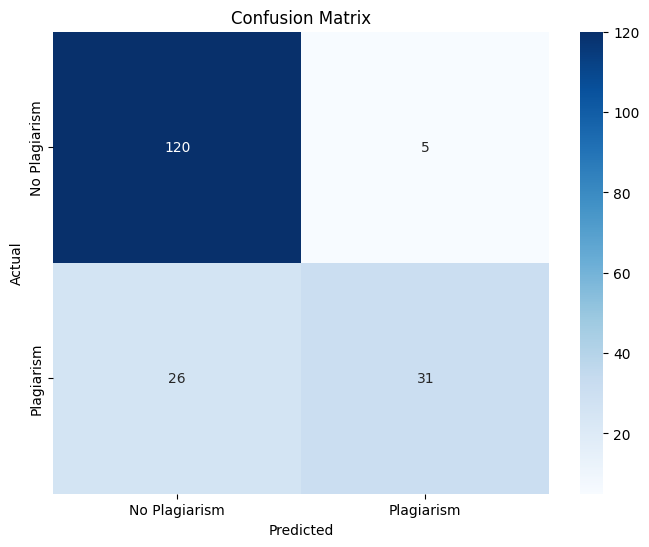

In [95]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Plagiarism', 'Plagiarism'], yticklabels=['No Plagiarism', 'Plagiarism'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()